### Predict sonic log from other geophysical logs with scikit-learn
Matteo Niccoli, MyCarta
Calgary, Alberta, Canada
mycarta.wordpress.com
matteo@mycarta.ca
@my_carta

This is a preliminary effort. I am sure some of the things I am doing by hand may be done with Pandas or Scikit-learn. I will keep experimenting and expanding on the code and notes/comments. Feedback, ideas, and comments are all welcome.

##### PRELIMINARIES

In [1]:
# Import main libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

##### IMPORT, CLEAN UP, SUMMARIZE, AND VISUALIZE DATA

First we import the logs from a csv file as a Pandas DataFrame, and check the data.

In [2]:
logs = pd.read_csv('qsiwell2_predict.csv')

print logs.columns
print (logs.head(5))
print(logs.dtypes)

Index([u'DEPTH', u'VP', u'VS', u'RHO_OLD', u'GR', u'NPHI', u'RHO', u'SW',
       u'SWX', u'VPVS', u'IP', u'IS', u'VSH', u'RHOm', u'RHOf', u'PHI'],
      dtype='object')
     DEPTH      VP     VS  RHO_OLD     GR  NPHI   RHO  SW  SWX  VPVS       IP  \
0  2013.25  2294.7  876.9     2.00  91.88  0.49   NaN NaN  NaN  2.62      NaN   
1  2013.41  2296.7  943.0     2.05  86.80  0.48  2.24   1    1  2.44  5144.85   
2  2013.56  2290.4  912.5     2.11  86.00  0.45  2.24   1    1  2.51  5135.74   
3  2013.71  2277.5  891.6     2.20  87.36  0.41  2.24   1    1  2.55  5107.98   
4  2013.86  2262.0  890.5     2.20  90.40  0.43  2.24   1    1  2.54  5067.02   

        IS   VSH  RHOm  RHOf   PHI  
0      NaN  0.49  2.73   NaN   NaN  
1  2112.42  0.44  2.72  1.09  0.29  
2  2046.09  0.43  2.72  1.09  0.29  
3  1999.68  0.44  2.72  1.09  0.29  
4  1994.78  0.48  2.73  1.09  0.30  
DEPTH      float64
VP         float64
VS         float64
RHO_OLD    float64
GR         float64
NPHI       float64
RHO     

Let's remove a few columns we do not need, and the first row, which had a few empty cells, and check the data again.

In [3]:
col_names = ['VS','RHO_OLD','SW','SWX','VPVS','IP','IS','VSH','RHOm','RHOf','PHI']
logs.drop(col_names, axis=1, inplace=True)

logs=logs.iloc[1:,:] # first row had some empty cells
 
print logs.shape # number of rows and columns
print (logs.head(3)) # display first 3 rows
print(logs.dtypes) # column data types

(4116, 5)
     DEPTH      VP     GR  NPHI   RHO
1  2013.41  2296.7  86.80  0.48  2.24
2  2013.56  2290.4  86.00  0.45  2.24
3  2013.71  2277.5  87.36  0.41  2.24
DEPTH    float64
VP       float64
GR       float64
NPHI     float64
RHO      float64
dtype: object


In [4]:
print logs.shape # checking number of rows and columns

(4116, 5)


Now we can Create a scatter matrix with the pairwise scatter plots and hystogram distribution in the main diagonal.
I also add to each the value of the pairwise correlation coefficients. 

This can help learn the data, and answer several questions, among which:
- are there obvious distributions (normal, exponential, etc.)?
- are there any obvious linear relationships between the target log and any of the independent logs?

It could also be used (but  I won't be showing it in here) for attribute culling, or pruning of either redundant attributes (highly correlated between one another), or attributes that are not significant (in an inferential sense).
For example, one could look for any two pairs of independent logs that have pairwise correlation coefficient > 0.9, and eliminate one of the two.
One could also drop any of the independent logs that had correlation coefficient with the target log 
lower than the critical r. 

For more on these topics, please see: <a href="http://greenteapress.com/thinkstats/html/index.html"> Think Stats, by Allen B. Downey</a>.

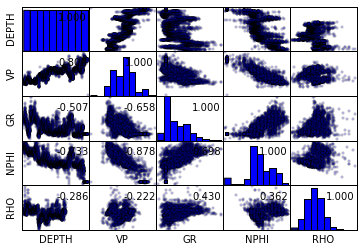

In [6]:
# create scatter matrix
axes = pd.tools.plotting.scatter_matrix(logs, marker='.', alpha=0.2, diagonal='hist') 
# if you prefer density plots to hystograms, comment line above and uncomment line below:
#axes = pd.tools.plotting.scatter_matrix(logs, marker='.', alpha=0.2, diagonal='kde') 

# calculate pairwise correlation coefficients
corr = logs.corr().as_matrix()

# add pairwise correlation coefficients to the scatter matrix in the lower triangle
for i, j in zip(*plt.np.tril_indices_from(axes, k=0)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.75, 0.75), xycoords='axes fraction', ha='center', va='center')

# add pairwise correlation coefficients to the scatter matrix in the upper triangle
#for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
     #axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')    

# remove tick marks and tick labels
for subaxis in axes:
        for ax in subaxis:
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
plt.show()

###### NB Some of the figures in this Notebook, particularly the scatter matrix, is better plotted externally by removing the  - %matplotlib inline - command in the preliminaries. Each figure then will plot to an external window with GUI to resize it, adjust it, and save to a PNG file. 

By just looking at the scatterplots I'd say there is some hope to predict the sonic from the other logs. I see some linear trends and relatively significant coefficients. A side note: if you are curious as to how you could access a portion of attr.describe() results (it is a Pandas Series) check <a href="http://stackoverflow.com/questions/19124148/modify-output-from-python-pandas-describe"> this Stackoverflow question.</a>

We can print the (Pearson) correlation coefficients as a matrix.

In [7]:
np.set_printoptions(precision=2)
pc= logs.corr().as_matrix()
print pc

[[ 1.    0.81 -0.51 -0.73 -0.29]
 [ 0.81  1.   -0.66 -0.88 -0.22]
 [-0.51 -0.66  1.    0.7   0.43]
 [-0.73 -0.88  0.7   1.    0.36]
 [-0.29 -0.22  0.43  0.36  1.  ]]


To make it prettier / more readable we add some labels to that matrix and convert it to a new DataFrame.

In [8]:
pcdf = pd.DataFrame(pc, index=list(logs.columns), 
                    columns=list(logs.columns))
pcdf

,DEPTH,VP,GR,NPHI,RHO
DEPTH,1.000000,0.805608,-0.507473,-0.732916,-0.285614
VP,0.805608,1.000000,-0.657569,-0.878139,-0.221998
GR,-0.507473,-0.657569,1.000000,0.697922,0.429566
NPHI,-0.732916,-0.878139,0.697922,1.000000,0.361965
RHO,-0.285614,-0.221998,0.429566,0.361965,1.000000


We can also get the Spearman correlation coefficients as a matrix. The Spearman cefficient is at time more suitable if the data has outliers, skewed distributions / non linear relationships. In this case (see below) the differences are minor.

In [9]:
np.set_printoptions(precision=2)
pcs= logs.corr(method='spearman').as_matrix()
print pcs

[[ 1.    0.79 -0.52 -0.73 -0.33]
 [ 0.79  1.   -0.67 -0.87 -0.27]
 [-0.52 -0.67  1.    0.74  0.48]
 [-0.73 -0.87  0.74  1.    0.37]
 [-0.33 -0.27  0.48  0.37  1.  ]]


In [10]:
pcsdf = pd.DataFrame(pcs, index=list(logs.columns), 
                    columns=list(logs.columns))
pcsdf

,DEPTH,VP,GR,NPHI,RHO
DEPTH,1.000000,0.791996,-0.520553,-0.730537,-0.334087
VP,0.791996,1.000000,-0.668515,-0.874705,-0.266345
GR,-0.520553,-0.668515,1.000000,0.742576,0.479602
NPHI,-0.730537,-0.874705,0.742576,1.000000,0.372761
RHO,-0.334087,-0.266345,0.479602,0.372761,1.000000


And use the .describe() method to get some statistics that "summarize" the data.

In [11]:
logs.describe()

,DEPTH,VP,GR,NPHI,RHO
count,4116.000000,4116.000000,4116.000000,4116.000000,2701.000000
mean,2326.968200,2977.264553,72.780209,0.321259,2.225198
std,181.101671,449.284198,14.463176,0.089937,0.061964
min,2013.410000,1439.900000,48.370000,0.070000,2.040000
25%,2170.182500,2594.575000,60.680000,0.280000,2.190000
50%,2326.965000,3036.300000,68.020000,0.310000,2.220000
75%,2483.747500,3251.100000,83.537500,0.390000,2.260000
max,2640.530000,4431.000000,136.510000,0.530000,2.550000


Let's look at the target VP sonic log versus depth

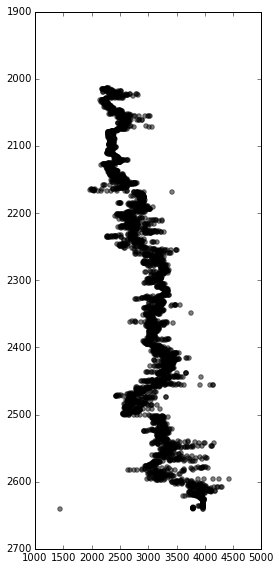

In [12]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs["VP"], logs["DEPTH"], color = 'k', alpha=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

There's one obvious bad value at max depth that we can eliminate (it's the lowest value of VP, easily highlighted).

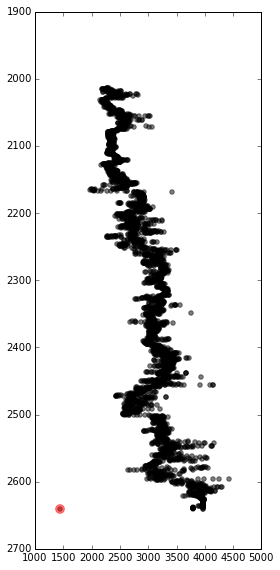

In [13]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs["VP"], logs["DEPTH"], color = 'k', alpha=0.5)
templogs = logs[(logs["VP"]==logs["VP"].min())]
ax1.scatter(templogs["VP"], templogs["DEPTH"], s=75, color = 'r', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Now we can remove the data point, then plot again.

In [14]:
logs = logs[~(logs["VP"]==logs["VP"].min())]

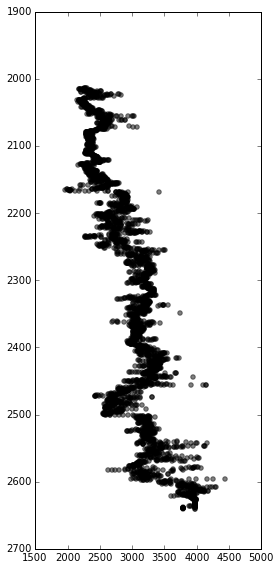

In [15]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs["VP"], logs["DEPTH"], color = 'k', alpha=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

##### MAKING PREDICTIONS. LINEAR CORRELATION IN SCIKIT-LEARN.

The first task is to deal with any missing data. We can use Pandas' .isnull() method to tell us if a column had any null values and how many.

In [16]:
for x in logs.columns:
  print x, logs[x].isnull().values.any()

logs.isnull().sum() # finds how many missing points there are

DEPTH False
VP False
GR False
NPHI False
RHO True


DEPTH       0
VP          0
GR          0
NPHI        0
RHO      1414
dtype: int64

By the way, I found some very good examples on the various ways to deal with missing data in Pandas dataframes in <a href="http://chrisalbon.com/python/pandas_missing_data.html"> this article. </a>


Anyway, it looks like there are several missing data points in the density log. We will replace missing density values with the mean density, then check again.

In [17]:
logs['RHO'].fillna(logs['RHO'].mean(),inplace=True)

for x in logs.columns:
  print x, logs[x].isnull().values.any() 

DEPTH False
VP False
GR False
NPHI False
RHO False


We can now attempt to predict VP using th other columns (yes, including depth as velocity, generally speaking, increases with depth, thanks to sediment compaction).

We want to train the linear predictor on a subset of the velicty data that is different from the one we will make predictions on, which allows us to avoid overfitting. One nice way to do that is through cross validation, a process of splitting the data into several chunks called folds. Say we split the logs in five folds of the smae size. In the first iteration, we combine the first four parts, train the predictor, then make predictions on the fifth part, and measure accuracy. In the second iteration, we combine the first part with the third, fourth, and fifth, train the predictor, make predictions on the second part, measure accuracy again, and so on. In this way we make predictions for the whole dataset without calculating accuracy on the same data we train our model on.

For this crossvalidation part, I relied heavily on what I learned in the <a href="https://www.dataquest.io/mission/74/getting-started-with-kaggle/"> intro to Kaggle competitions</a>, to which I just added the for loop over the scores to determine the optimal fold.

In [18]:
# iterate over possible number of cross validation folds to check scores and decide optimal fold 
from sklearn.cross_validation import cross_val_score

# Import the linear regression class
from sklearn.linear_model import LinearRegression

# The columns we'll use to predict the target
predictors = ['DEPTH', 'GR', 'NPHI', 'RHO']

# Initialize our algorithm class
alg = LinearRegression()

scores = []
for i in np.arange(2, 15, 1):
    score = cross_val_score(alg, logs[predictors], logs["VP"], cv=i)
    scores.append(np.mean(score))
    # Take the mean of the scores (because we have one for each fold)

print scores
#scores=np.asarray(scores)
#print np.mean(scores, axis=0)

[0.26821114187016437, 0.22009341243636338, 0.13971372212517222, 0.032410632093280142, 0.28498303638205308, 0.19849678305911467, -0.066544564800345374, -0.21514908141853695, -0.56700683194299939, -0.026375890512326673, -0.14798157072366611, -0.21141153414829941, -0.26245085321042672]


###### The scores above are low (scores are in the range 0-1). We will address this in just a bit.

For now let's just apply the number of folds (3) we jut determined in [25] to run the cross validated prediction using the optimal number of folds.

In [19]:
from sklearn.cross_validation import KFold

# Generate cross validation folds. It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(logs.shape[0], n_folds=3, random_state=1)

# remember that predictors = ['DEPTH', 'GR', 'NPHI', 'RHO']
predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm. Note how we only take the rows in the train folds.
    train_predictors = (logs[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = logs["VP"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(logs[predictors].iloc[test,:])
    predictions.append(test_predictions)

And now we can show the split of velocity values in the train and test set, which will clarify the reason for the low scores.

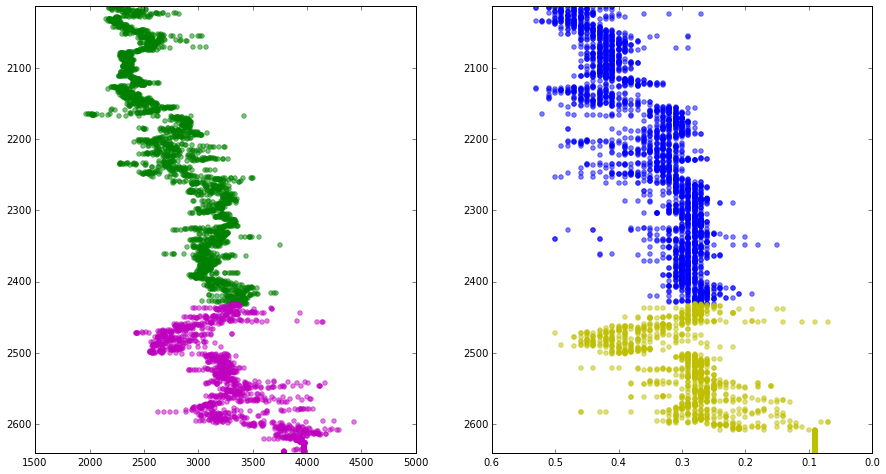

In [20]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))

axs[0].scatter(logs["VP"].iloc[train], logs["DEPTH"].iloc[train], color = 'g', alpha=0.5)
axs[0].scatter(logs["VP"].iloc[test], logs["DEPTH"].iloc[test], color = 'm', alpha=0.5)
axs[0].set_ylim([max(logs["DEPTH"]), min(logs["DEPTH"])])

axs[1].invert_xaxis()
axs[1].scatter(logs["NPHI"].iloc[train], logs["DEPTH"].iloc[train], color = 'b', alpha=0.5)
axs[1].scatter(logs["NPHI"].iloc[test], logs["DEPTH"].iloc[test], color = 'y', alpha=0.5)
axs[1].set_ylim([max(logs["DEPTH"]), min(logs["DEPTH"])])

plt.show()

Because the velocity VP increases with depth, in the split above, the range of values in the train set (green) does not cover the entire range of values in the test set (magenta). In the left subplot you will notice there are a lot of points with values of VP > 3750 m/s in the test split, but none in the train split. 

Similarly, the neutron NPHI, the top predictor of VP, has values decreasing with depth, so in the right subplot above, there are very low values in the test set (yellow) but hardly any in the train set (blue).

__*I am thinking the reason why the scores are so poor in the output of [17] may have to do with this. But I am still on the fence, and trying to wrap my head around it. Could you argue that because the values of predictors (or just one, the neutron) linearly predict the target (velocity), this does not matter at all?*__

__*As we will see a few blocks of code further, a random shuffle prior to the prediction seems to take care of the problem with low scores. Why would that be, if it has not to do with the way the logs are split in train and test data sets by kfold?*__

But before we get to that, let's look at all three splits in kfold.

We modify the for loop from [18] by adding plots dynamically, as suggested in http://stackoverflow.com/a/17211410,
accessing the individual splits as suggested in http://stackoverflow.com/a/27381010.

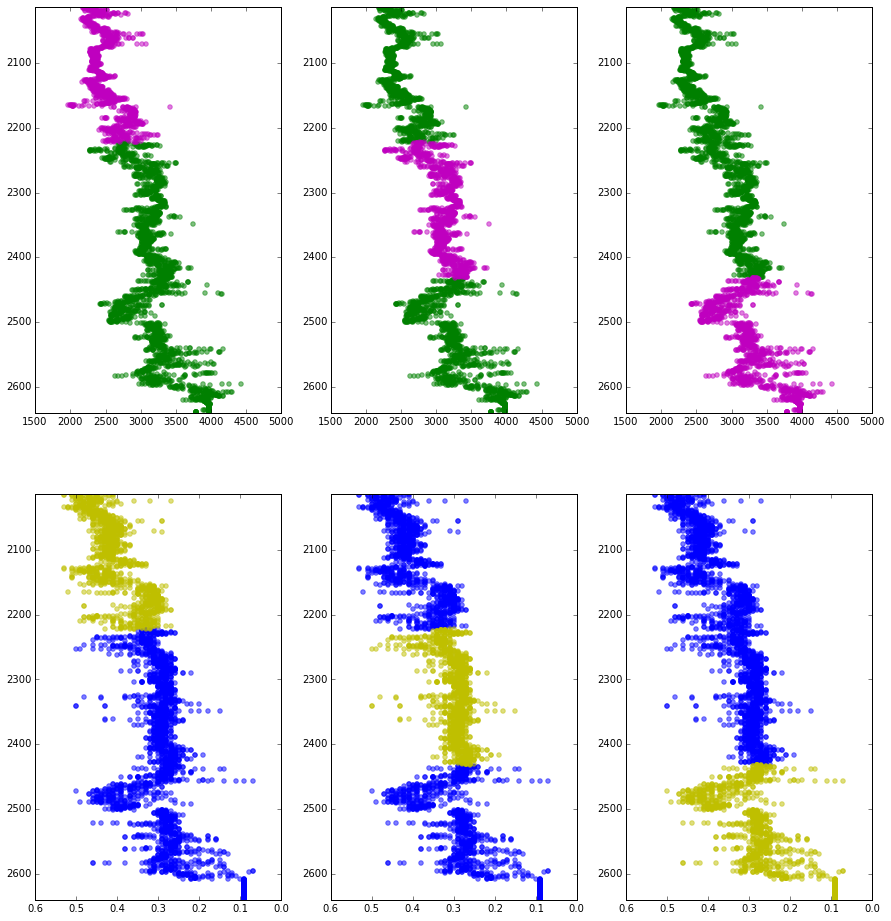

In [21]:
mylist = list(kf)
n_folds=3

fig, axs = plt.subplots(2,3, figsize=(15, 16))
#fig.subplots_adjust(hspace = .5, wspace=.001)

for i in range(n_folds):
    train, test = mylist[i]
    axs[0,i].scatter(logs["VP"].iloc[train], logs["DEPTH"].iloc[train], color = 'g', alpha=0.5)
    axs[0,i].scatter(logs["VP"].iloc[test], logs["DEPTH"].iloc[test], color = 'm', alpha=0.5)
    axs[0,i].set_ylim([max(logs["DEPTH"]), min(logs["DEPTH"])])
    
    axs[1,i].invert_xaxis()
    axs[1,i].scatter(logs["NPHI"].iloc[train], logs["DEPTH"].iloc[train], color = 'b', alpha=0.5)
    axs[1,i].scatter(logs["NPHI"].iloc[test], logs["DEPTH"].iloc[test], color = 'y', alpha=0.5)
    axs[1,i].set_ylim([max(logs["DEPTH"]), min(logs["DEPTH"])])
    
plt.show()

Let's repeat the process but with a randome shuffle at the beginning.

Prior to the shuffle we create a column with the original indices so that we can undo the shuffle if needed.

In [22]:
idx = np.array(logs.index) # get the index column in the original DataFrame
print idx[:10]

logs["idx"] = idx # add the index and the predictions as columns to the logs DataFrame

print list(logs) # check new columns are in

import random # Set a random seed to make the shuffle deterministic and repeatable 
np.random.seed(1)
random.seed(1)

logs1 = logs.loc[np.random.permutation(logs.idx)] # shuffle

print logs1.head(5) # checking shuffle with index column

[ 1  2  3  4  5  6  7  8  9 10]
['DEPTH', 'VP', 'GR', 'NPHI', 'RHO', 'idx']
        DEPTH      VP     GR  NPHI       RHO   idx
2511  2395.93  3066.7  64.76  0.28  2.180000  2511
2750  2432.35  3361.6  62.16  0.28  2.225198  2750
3666  2571.95  3135.0  61.16  0.28  2.225198  3666
561   2098.75  2368.4  97.54  0.46  2.250000   561
2929  2459.63  2780.4  81.70  0.33  2.225198  2929


Now we chack the cross validation scores again. I expect they will be higher.

In [23]:
scores = []
for i in np.arange(2, 15, 1):
    score = cross_val_score(alg, logs1[predictors], logs1["VP"], cv=i)
    scores.append(np.mean(score))
    # Take the mean of the scores (because we have one for each fold)
    
print scores
#scores=np.asarray(scores)
#print np.mean(scores, axis=0)

[0.84359018846440836, 0.84363683142024171, 0.84371660687892991, 0.84373433441956425, 0.84369840705849108, 0.84374973508195428, 0.84372953701563225, 0.84329019238702441, 0.84348088562769186, 0.84321140959460839, 0.8432735725328997, 0.84360656931835643, 0.84298182724381987]


They are indeed, and the optimal fold is also different, you will notice (it is 7). Let's run the cross validated prediction using this optimal number of folds.

In [24]:
kf = KFold(logs1.shape[0], n_folds=7, random_state=1)

# remember that predictors = ['DEPTH', 'GR', 'NPHI', 'RHO']
predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm. Note how we only take the rows in the train folds.
    train_predictors = (logs1[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = logs1["VP"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(logs1[predictors].iloc[test,:])
    predictions.append(test_predictions)

##### EVALUATING PREDICTION PERFORMANCE.

One way to evaluate the prediction performance is to create a baseline model against which every predicted model will have to be compared. In the absence of any predictor, if all we could use is the dependent, target log variable, the best we could do with predicting a new, unmeasured sonic value, would be to use the sonic mean. (That is not entirely correct. I think it would be correct if the values of sonic from sample to sample were completely independent, but even without the depth log, we do know that the sonic, on average, increases with sample number, at least in this geological province; so a very long running average might be a better baseline model; I will get back to this, so for now forgive the oversimplification).

In [25]:
baseline = np.full(logs1["VP"].shape, logs1["VP"].mean()) # create baseline model.
print baseline.shape
print baseline [:5]

(4115,)
[ 2977.64  2977.64  2977.64  2977.64  2977.64]


Now we plot the baseline model consisting of cvalues equal to the mean at each sample. The diagonal line represent perfect prediction.

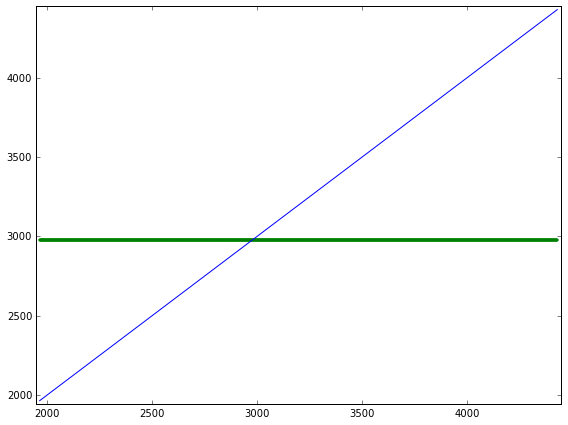

In [26]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

ax1.scatter(np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]), 
            baseline, s=3, color = 'g', alpha=0.5)

ax1.plot(np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]), 
         np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]))

ax1.set_xlim([logs1["VP"].min()- 20, logs1["VP"].max() + 20])
ax1.set_ylim([logs1["VP"].min()- 20, logs1["VP"].max() + 20])

plt.tight_layout()
plt.show()

Now we can compare the result of the linear prediction agains the perfect prediction in the diagonal line.

In [27]:
prediction = np.concatenate(predictions, axis=0)
# The predictions are in three separate numpy arrays, so we need to concatenate them into one.  

In [28]:
print prediction.shape
print logs1["VP"].shape

(4115,)
(4115,)


And here's the plot of predicted versus actual, linear model. Diagonal line is perfect prediction.

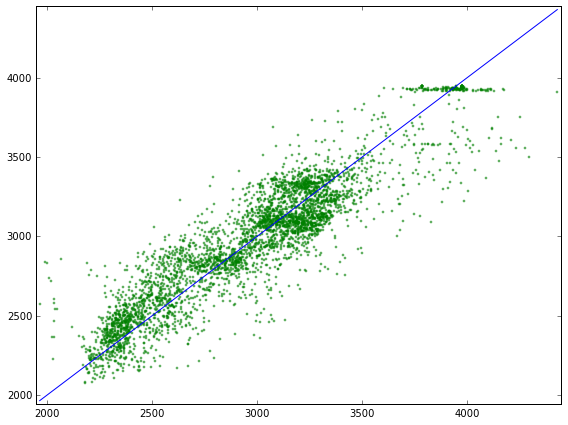

In [29]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

ax1.scatter(logs1["VP"], prediction, s=3, color = 'g', alpha=0.5)

ax1.plot(np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]), 
         np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]))

ax1.set_xlim([logs1["VP"].min()- 20, logs1["VP"].max() + 20])
ax1.set_ylim([logs1["VP"].min()- 20, logs1["VP"].max() + 20])

plt.tight_layout()
plt.show()

We have definitely made an improvement in our prediction compared to the baseline model.

To conclude this part, I want to compare the predicted sonic to the actual sonic. To do that we need to undo the random shuffle in the predicted values with the indeces created in [22].

In [30]:
logs1["predictedVP"] = prediction # adding the prediction so it is in the final DataFrame
logs2 = logs1.sort_values(['idx'], ascending=[True]) # undo the random shuffle

Although we could have done the same, since we have them, by DEPTH values.

In [31]:
#logs2 = logs1.sort(['DEPTH'], ascending=[True])

Original versus predicted sonic, as scatter plots.

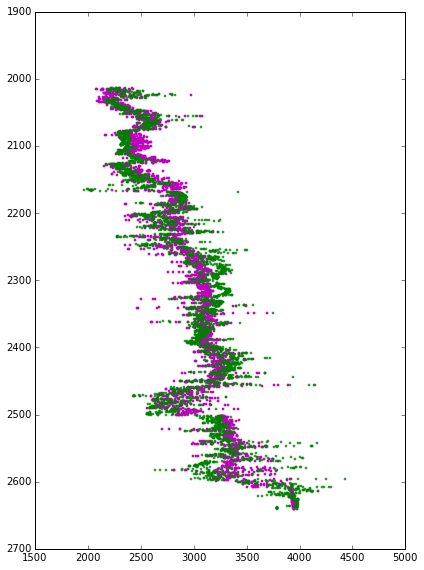

In [32]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs2["predictedVP"], logs2["DEPTH"], s = 3, color = 'm')
ax1.scatter(logs2["VP"], logs2["DEPTH"], s = 3, color = 'g', alpha = 0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Original versus predicted sonic, as scatter plots.

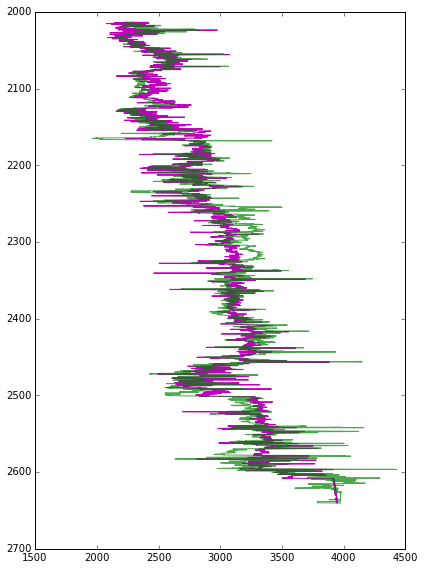

In [33]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111)
ax1.plot( logs2["predictedVP"], logs2["DEPTH"],'m')
ax1.plot( logs2["VP"], logs2["DEPTH"],'g', alpha=0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

##### COMING SHORTLY

- try a different baseline model. Look at time series analysis, stock price prediction examples
- prediction using scikit-learn Random Forest
- (perhaps) prediction using scikit-learn Sup[port Vector Regression with nonlinear kernel
- adding numerical metrix to compare models to baseling and to one another (RMSE, MAE)